## Simulating sequence data based on our best-fit demographic model

In this notebook, we're going to simulate data based on the maximum likelihood parameter estimates from our best-fit demographic model, and then compare the SFS from these data with the SFS from our empirical data. We'll start by importing the `Python` packages we'll use:

In [3]:
# suppress gnarly matplotlib warnings
import warnings
def action_with_warnings():
    warnings.warn("should not appear")

# import other libraries
import allel
import moments
import msprime
import tskit
import numpy as np
import seaborn as sns

Next, let's import the `.vcf` we used in `moments`:

In [5]:
# load vcf and extract folded sfs; write to file
vcf_file = "/Users/ethanlinck/Dropbox/wagtails/data/demographic_inf_parentals_rename.vcf"
f = allel.read_vcf(vcf_file, fields='*')
gt = f['calldata/GT']
gt = allel.GenotypeArray(gt)
personata=gt[:,0:10]
alba=gt[:,10:20]
gn_p = personata.to_n_alt(fill=-1)
gn_a = alba.to_n_alt(fill=-1)
p_unlinked = allel.locate_unlinked(gn_p)
a_unlinked = allel.locate_unlinked(gn_a)
pass_linkage = np.logical_and(p_unlinked, a_unlinked)
final = gt.compress(pass_linkage, axis=0)
personata2=final[:,0:10]
alba2=final[:,10:20]
pers_ac = personata2.count_alleles()
alba_ac = alba2.count_alleles()
fsfs = allel.joint_sfs_folded(pers_ac, alba_ac)
m_fsfs = moments.Spectrum(fsfs)

How many variants? We'll need this for our simulations.

In [6]:
variant_count = final.n_variants
variant_count

549501

Next, let's calculate basic summary statistics: $F_{ST}$, $\pi$, and $D_{XY}$. First, we'll assign subpopulations:

In [7]:
alba = list(range(0,10))
personata = list(range(10,20))
populations = [alba, personata]

Now, the summary stats themselves, which will save for comparison to simulated results later. Genome-wide $F_{ST}$:

In [178]:
a, b, c = allel.weir_cockerham_fst(final, populations)
empirical_fst = np.sum(a) / (np.sum(a) + np.sum(b) + np.sum(c))
empirical_fst

0.06371249429456141

Genome-wide $\pi$:

In [9]:
ac = final.count_alleles()
mpd = allel.mean_pairwise_difference(ac)
total_length = gt.n_variants
empirical_pi = np.sum(mpd)/total_length
empirical_pi

0.005314163319711882

And now $D_{XY}$:

In [11]:
ac2 = final.count_alleles(subpop=alba)
ac3 = final.count_alleles(subpop=personata)
mpdb = allel.mean_pairwise_difference_between(ac2, ac3)
empirical_dxy = np.sum(mpdb)/total_length
empirical_dxy

0.005516508746638577

We'll now define the demographic model we'll use to simulate these data:

In [179]:
def wagtail_history():

    # maximum likelihood values for population sizes in absolute units...
    n_alba = 283484
    n_personata = 253026
    
    #...split times in generations / years...
    t_split = 77401
    t_contact = 433
    
    #...and proprotional migration rates
    m_alba_personata = 2.616447e-05
    m_personata_alba = 3.668411e-07
    
    # population configurations indices: 0=alba, 1=personata
    population_configurations = [
        msprime.PopulationConfiguration(sample_size=10, initial_size=n_alba),
        msprime.PopulationConfiguration(sample_size=10, initial_size=n_personata),
    ]
    
    # migration matrix based on those indices
    migration_matrix = [
        [      0, m_alba_personata],
        [m_personata_alba,       0],
    ]
    
    # demographic events: cessation of hybridization + initial divergence
    demographic_events = [
        msprime.MigrationRateChange(time=t_contact, rate=0),
        msprime.MassMigration(time=t_split, source=1, destination=0, proportion=1.0),
    ]
    
    # return matrix objects
    return {
        "population_configurations": population_configurations,
        "migration_matrix": migration_matrix,
        "demographic_events": demographic_events,
    }

Let's use the `DemographyDebugger()` function to make sure we have gene flow for the most recent time period, a period of isolation, and then a "mass migration event" (i.e., divergence):

In [180]:
dd = msprime.DemographyDebugger(**wagtail_history())
dd.print_history()

Model =  hudson(reference_size=1)
Epoch: 0 -- 433.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |2.83e+05 2.83e+05              0 |     0    2.62e-05 
1 |2.53e+05 2.53e+05              0 | 3.67e-07     0    

Events @ generation 433.0
   - Migration rate change to 0 everywhere
Epoch: 433.0 -- 77401.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |2.83e+05 2.83e+05              0 |     0        0    
1 |2.53e+05 2.53e+05              0 |     0        0    

Events @ generation 77401.0
   - Mass migration: Lineages moved with probability 1.0 backwards in time with source 1 & dest 0
                     (equivalent to migration from 0 to 1 forwards in time)
Epoch: 77401.0 -- inf generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |2.83e+05 2.83e+05   

Looks good! We'll now run a full simulation, trying to mimic our data as closely as possible.

In [183]:
def replicate_simulations(num_replicates): 
    
    # assign blank numpy arrays
    P = np.zeros(num_replicates)
    D = np.zeros(num_replicates)
    F = np.zeros(num_replicates)
    A = [range(0, num_replicates)]
    
    # get population indices with summary statistics
    alba = list(range(0,10))
    personata = list(range(10,20))
    populations = [alba, personata]
    
    # msprime function
    replicates = msprime.simulate(**wagtail_history(),
                     length=1e5,
                     recombination_rate = 3.63e-8,
                     mutation_rate = 2.3e-9,
                     num_replicates = num_replicates)
    
    # loop over replicated tree sequences 
    for j, tree_sequence in enumerate(replicates):
        P[j] = tree_sequence.diversity()
        D[j] = tree_sequence.divergence(sample_sets=populations)
        F[j] = tree_sequence.Fst(sample_sets=populations)
        A.append(tree_sequence.allele_frequency_spectrum(sample_sets=populations,
                                                         polarised=True, 
                                                         span_normalise=False))
        
    # print summary statistics
    print("        empirical                          simulated")
    print("Pi      {}\t\t{}".format(empirical_pi, np.mean(P)))
    print("Dxy     {}\t\t{}".format(empirical_dxy, np.mean(D)))
    print("Fst     {}\t\t{}".format(empirical_fst, np.nanmean(F)))
    
    # output allele frequence spectrum object
    return A


In [184]:
sim_afs = replicate_simulations(100)

        empirical                          simulated
Pi      0.005314163319711882		0.002790654210526298
Dxy     0.005516508746638577		0.002968475999999992
Fst     0.06371249429456141		0.06744866345526317


So while $F_{ST}$ is almost dead-on, we see lower diversity ($\pi$) and absolute divergence ($D_{xy}$) in out best-fit model than our empirical data—possibly due to failing to model population growth, or natural selection. 

Lastly, we'll visualize the source of these statistics—the joint allele / site frequency spectrum itself.

<AxesSubplot:xlabel='derived allele count (population 1)', ylabel='derived allele count (population 2)'>

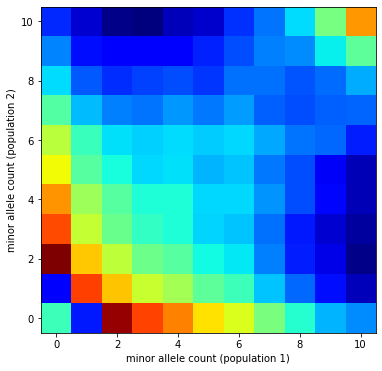

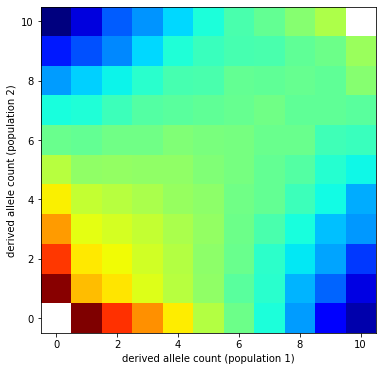

In [185]:
empirical_jsfs = allel.joint_sfs_folded(ac2,ac3)
allel.plot_joint_sfs_folded(empirical_jsfs)
mean_sim_afs = np.mean(sim_afs[1:100], axis=0)
mean_sim_afs.shape
allel.plot_joint_sfs(mean_sim_afs)

We can see that while there are similarities across spectra, there is an excess of intermediate frequency alleles in our simulated data compared to our empirical data—suggested either too-high migration, or (more likely) a failure to model demographic processes responsible for the higher number of rare alleles in the real data.